# AT3 - Airfare dataset modelling for prediction - SGD Regression 

## 1. Loading the datasets

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages and custom functions
import pandas as pd
import numpy as np
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the src directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))


from models.sets import load_sets
from models.performance import plot_regressor_scores
from models.null import NullRegressor
from models.data_exploration import display_data_info

In [3]:
# 1.3. Load the datasets
X_train, y_train, X_val, y_val, X_test, y_test = load_sets()

In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2075928, 8)
y_train shape: (2075928,)
X_val shape: (691976, 8)
y_val shape: (691976,)
X_test shape: (691976, 8)
y_test shape: (691976,)


In [5]:
display_data_info(X_train)

Top 5 rows of data:
  startingAirport destinationAirport departure_dayofweek  departure_month  \
0             DEN                PHL              Sunday                4   
1             DEN                ATL              Sunday                4   
2             DEN                PHL              Sunday                4   
3             DEN                LGA              Sunday                4   
4             DEN                DFW              Sunday                4   

   departure_hour  departure_minute cabin_type YearMonth  
0               6                30      coach   2022-04  
1               6                30      coach   2022-04  
2               6                30      coach   2022-04  
3               6                30      coach   2022-04  
4               6                35      coach   2022-04  
--------------------------------------------------------------------------------------------------------------
Bottom 5 rows of data:
        startingAirport desti

# 2. Baseline Model

RMSE Training: 220.33
MAE Training: 159.71


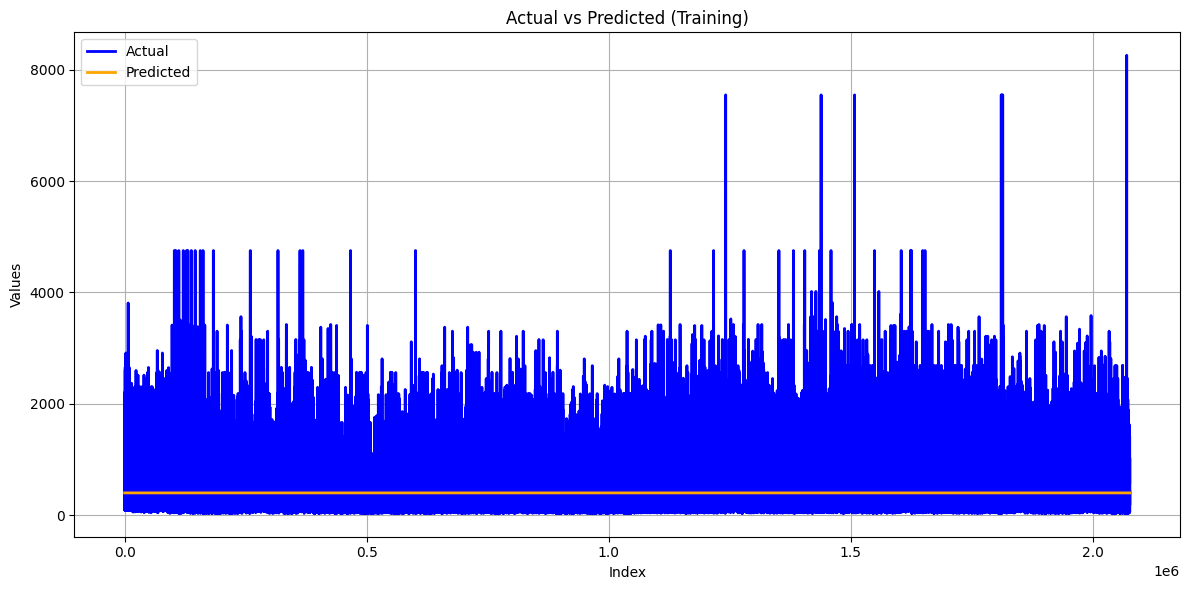

In [6]:
# Instantiate a NullRegressor and save it into a variable called base_model
base_model = NullRegressor()

# Make a prediction using fit_predict() and save the results in a variable called y_base
y_base = base_model.fit_predict(y_train)

# Converting to save memory
y_base = y_base.astype(np.float32)
y_train = y_train.astype(np.float32)

# Display the RMSE and MAE scores of this baseline model
plot_regressor_scores(y_preds=y_base, y_actuals=y_train, set_name='Training')

RMSE Validation: 220.17
MAE Validation: 160.85


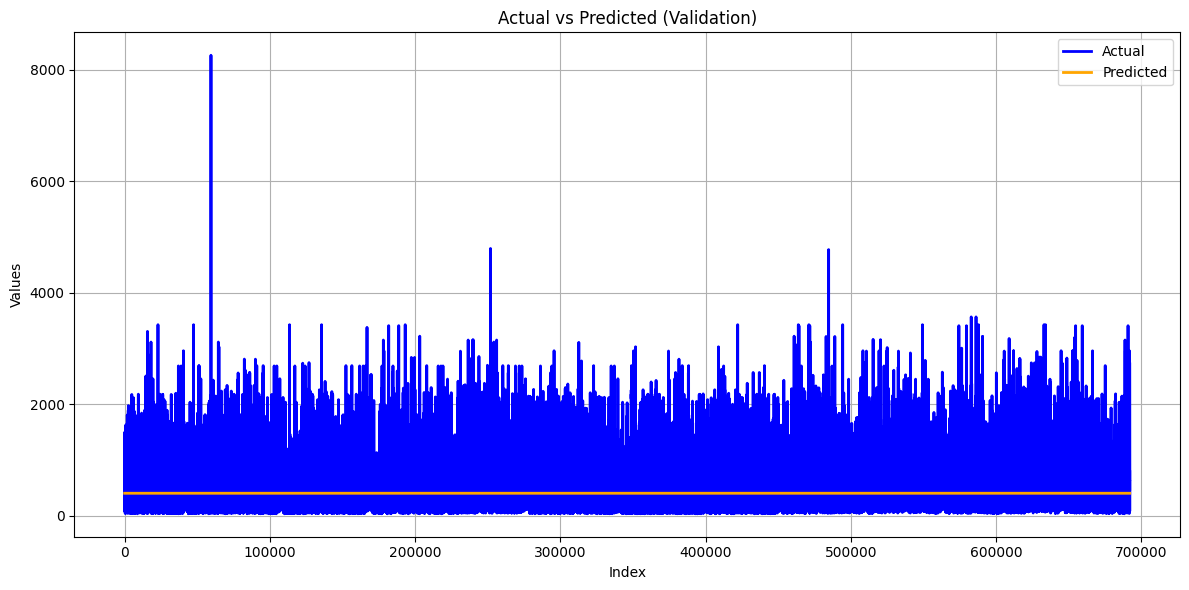

In [7]:
# Display the RMSE and MAE scores of this baseline model on the validation set
plot_regressor_scores(y_preds=base_model.predict(y_val), y_actuals=y_val, set_name='Validation')

## 3. Data transformation and Modelling

## 3.1 Pipelines for transformations

In [8]:
# Import packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from models.sets import cyclical_transform

In [9]:
# Specify the columns for cyclical features
cyclical_cols = ['departure_month', 'departure_hour', 'departure_minute']

# Specify categorical columns
cat_cols = ['startingAirport', 'destinationAirport', 'departure_dayofweek', 'cabin_type']

In [10]:
# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the cyclical transformer
cyclical_transformer = Pipeline(steps=[
    ('cyclical', FunctionTransformer(cyclical_transform, validate=False))
])

In [11]:
# Define which columns to apply each transformer to
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('cyclical', cyclical_transformer, cyclical_cols)
    ],
    remainder='drop' 
)

## 3.2 Modelling and Evaluation

### 3.2.1 Experiment A1: Modelling

In [12]:
# Create a Pipeline called sgd_pipe that contains 2 steps preprocessor and another that instantiates a Linear regressor.
# stochastic gradient descent algorithm, which iteratively updates the model weights based on a subset of the data (mini-batches) rather than the entire dataset.Suitable for large-scale datasets
sgd_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('sgd', SGDRegressor(penalty='elasticnet', random_state=42)) 
    ]
)

In [13]:
# Fit sgd_pipe with training dataset
sgd_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['startingAirport',
                                                   'destinationAirport',
                                                   'departure_dayofweek',
                                                   'cabin_type']),
                                                 ('cyclical',
                                                  Pipeline(steps=[('cyclical',
                                                                   FunctionTransformer(func=<function cyclical_transform at 0x0000022FE2BF3100>))]),
                                                  ['departure_month',
                                                   'departure_hour',
                                                   'departure_minute'])])),
                ('sgd', SGDRegressor(penalty='elasticnet', random_state=42))])

### 3.2.1.1 Experiment A1:Model Perfomance Evaluation 

In [14]:
# Make predictions on training dataset and store the predictions in train_preds
train_preds = sgd_pipe.predict(X_train)

RMSE Training: 180.50
MAE Training: 127.56


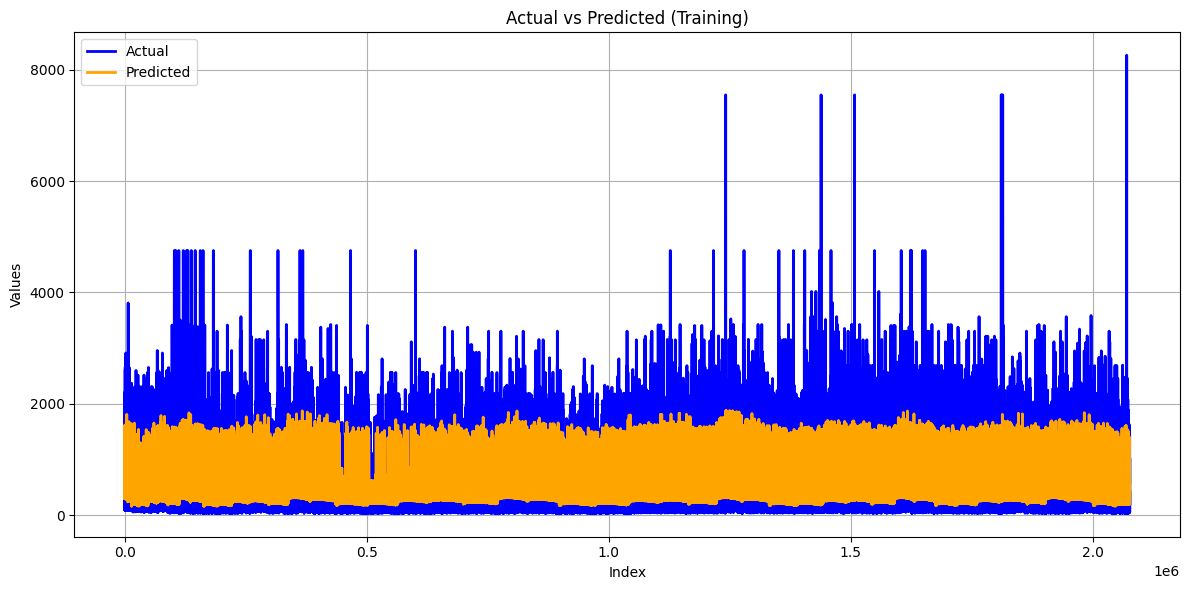

In [15]:
# Training data: Display the RMSE and MAE scores and plot the prediction of sgd model
plot_regressor_scores(y_preds=train_preds, y_actuals=y_train, set_name='Training')

RMSE Validation: 185.98
MAE Validation: 130.89


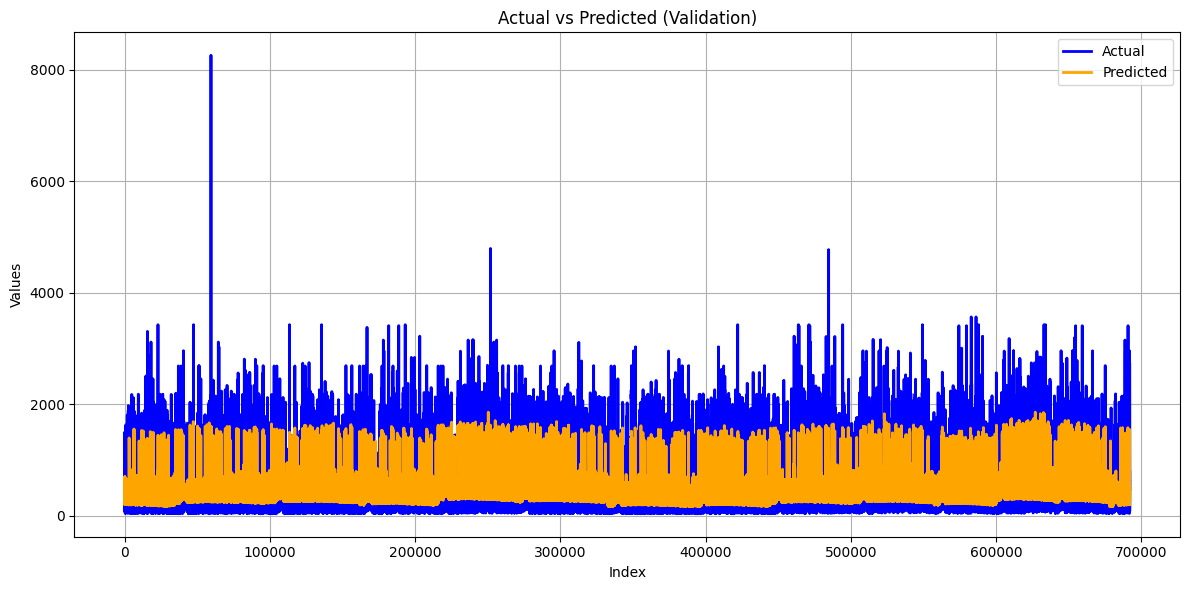

In [16]:
# Validation data: Display the RMSE and MAE scores and plot the prediction of sgd model
val_preds = sgd_pipe.predict(X_val)
plot_regressor_scores(y_preds=val_preds, y_actuals=y_val, set_name='Validation')

RMSE Test: 198.73
MAE Test: 146.27


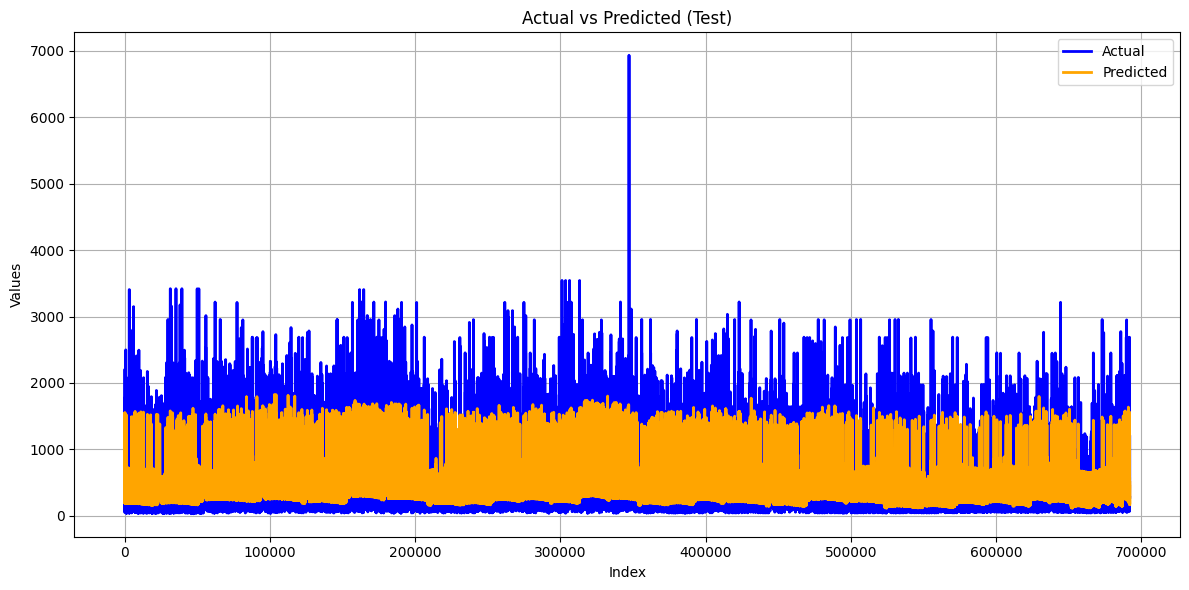

In [17]:
# Test data: Display the RMSE and MAE scores and plot the prediction of sgd model
test_preds = sgd_pipe.predict(X_test)
plot_regressor_scores(y_preds=test_preds, y_actuals=y_test, set_name='Test')

In [18]:
# Save the model 
# Import dump from joblib package and save sgd_pipe into models folder
from joblib import dump

dump(sgd_pipe,  '../models/pine_sgd_pipeline1.joblib')

['../models/pine_sgd_pipeline1.joblib']

### 3.2.2 Experiment A2: Modelling and hyper paramerter tuning using hyperopt

In [22]:
#Import package
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error


# Define the objective function for Hyperopt
def objective(params):
    # Create the pipeline with the current set of parameters
    sgd_pipe1 = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('sgd', SGDRegressor(
                penalty=params['penalty'],
                alpha=params['alpha'],
                eta0=params['eta0'],
                max_iter=int(params['max_iter']),
                tol=params['tol'],
                random_state=42
            ))
        ]
    )
    
    # Fit the model
    sgd_pipe1.fit(X_train, y_train)
    
    # Predict and calculate the mean squared error
    preds = sgd_pipe1.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    
    return {'loss': mse, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
    'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1)),
    'eta0': hp.loguniform('eta0', np.log(0.01), np.log(1)),
    'max_iter': hp.quniform('max_iter', 1000, 5000, 1000),
    'tol': hp.loguniform('tol', np.log(1e-5), np.log(1e-1))
}

# Trials object to track progress
trials = Trials()

# Run Hyperopt's fmin function
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    trials=trials
)

print("Best hyperparameters:", best)

100%|████████████████████████████████████████| 50/50 [39:39<00:00, 47.60s/trial, best loss: 34097.693900975784]
Best hyperparameters: {'alpha': np.float64(0.003132789538185341), 'eta0': np.float64(0.04074446362226317), 'max_iter': np.float64(2000.0), 'penalty': np.int64(0), 'tol': np.float64(0.0009845702868676745)}


In [23]:
# Result of the hyperopt hyperparameter tuning is Best hyperparameters: {'alpha': np.float64(0.003132789538185341), 
#'eta0': np.float64(0.04074446362226317),'max_iter': np.float64(2000.0), 'penalty': np.int64(0), 'tol': np.float64(0.0009845702868676745)}

# Best parameters obtained from Hyperopt
best_params = {
    'alpha': 0.003132789538185341,
    'eta0': 0.04074446362226317,
    'max_iter': 2000,
    'penalty': 'l1',  # Map from np.int64(0) to 'l1'
    'tol': 0.0009845702868676745
}

# Define the new pipeline with the best parameters
sgd_pipe2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('sgd', SGDRegressor(
            penalty=best_params['penalty'],
            alpha=best_params['alpha'],
            eta0=best_params['eta0'],
            max_iter=best_params['max_iter'],
            tol=best_params['tol'],
            random_state=42
        ))
    ]
)

In [25]:
# Fit sgd_pipe2 with training dataset
sgd_pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['startingAirport',
                                                   'destinationAirport',
                                                   'departure_dayofweek',
                                                   'cabin_type']),
                                                 ('cyclical',
                                                  Pipeline(steps=[('cyclical',
                                                                   FunctionTransformer(func=<function cyclical_transform at 0x0000022FE2BF3100>))]),
                                                  ['departure_month',
                                                   'departure_hour',
                                                   'departure_minute'])])),
                ('sgd',
                 SGDRegressor(alpha=0.003132789538185341,
                              eta0=0.04074446362226317, max_iter=2000,
                              penalty='l1', random_state=42,
                              tol=0.0009845702868676745))])

RMSE Training: 180.63
MAE Training: 128.06


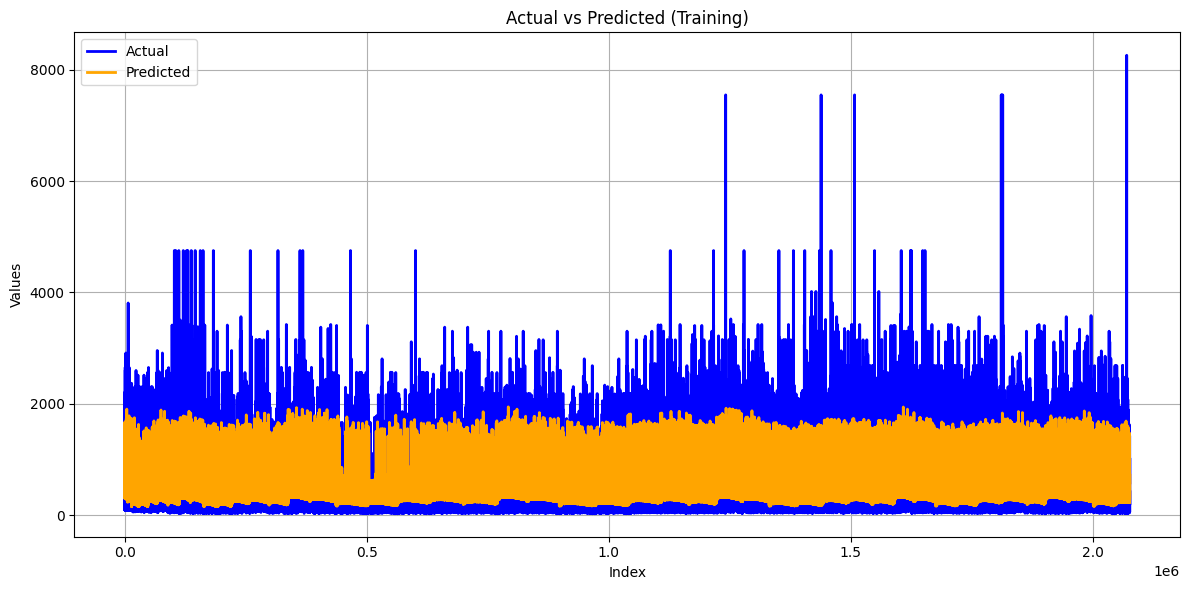

In [26]:
# Make predictions on training dataset and store the predictions in train_preds
train_preds = sgd_pipe2.predict(X_train)

# Training data: Display the RMSE and MAE scores and plot the prediction of sgd model
plot_regressor_scores(y_preds=train_preds, y_actuals=y_train, set_name='Training')

RMSE Validation: 184.66
MAE Validation: 131.84


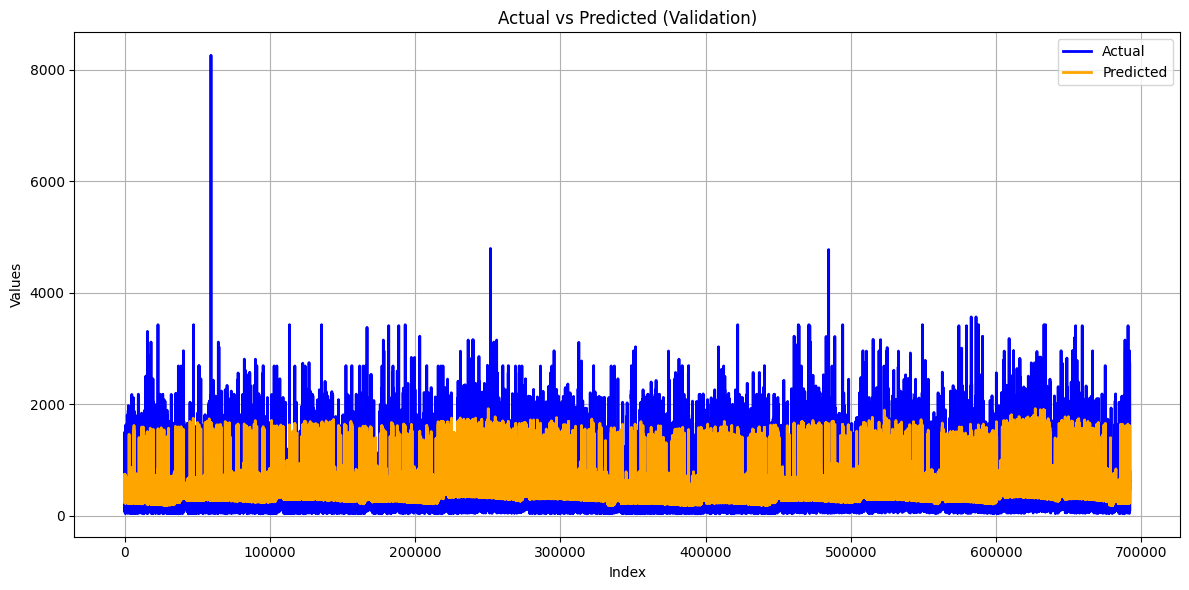

In [27]:
# Validation data: Display the RMSE and MAE scores and plot the prediction of sgd model
val_preds = sgd_pipe2.predict(X_val)
plot_regressor_scores(y_preds=val_preds, y_actuals=y_val, set_name='Validation')

RMSE Test: 185.56
MAE Test: 136.07


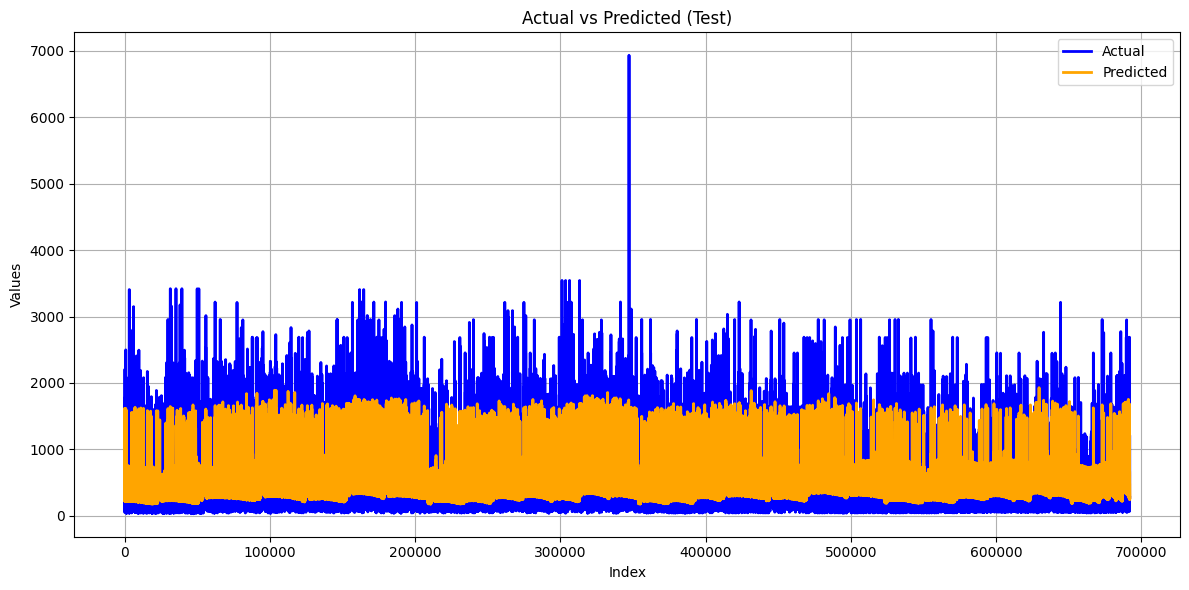

In [28]:
# Test data: Display the RMSE and MAE scores and plot the prediction of sgd model
test_preds = sgd_pipe2.predict(X_test)
plot_regressor_scores(y_preds=test_preds, y_actuals=y_test, set_name='Test')

In [29]:
# Save the model 
# Import dump from joblib package and save sgd_pipe into models folder
from joblib import dump

dump(sgd_pipe2,  '../models/pine_sgd_pipeline2.joblib')

['../models/pine_sgd_pipeline2.joblib']